## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i ,units in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation='softmax', name='out_layer')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_batch_begin(self, epoch, logs={}):
        logs = logs or {}
        record_items = ['val_tp', 'val_tn']
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
        print(self.params['metrics'])
    
    def on_epoch_end(self, epoch, logs={}, thres=0.5):
        logs = logs or {}
        print(self.validation_data)
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:,1] >= thres) * 1
        
        val_tp = sum(y_true*y_pred)
        val_tn = sum((y_true==0) & (y_pred==0))
        
        logs['val_tp'] = val_tp
        logs['val_tn'] = val_tn
rec_tptn = Record_tp_tn()

In [13]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train,y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test,y_test),
         shuffle=True,
         callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________

50000/50000 [==============================] - 11s 219us/step - loss: 2.2286 - acc: 0.2726 - val_loss: 2.1243 - val_acc: 0.2280
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.],

50000/50000 [==============================] - 8s 167us/step - loss: 1.7503 - acc: 0.3903 - val_loss: 1.9827 - val_acc: 0.2679
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 175us/step - loss: 1.6250 - acc: 0.4324 - val_loss: 1.8370 - val_acc: 0.3549
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

Epoch 5/25
['loss', 'acc', 'val_loss', 'val_acc', 'val_tp', 'val_tn']
50000/50000 [==============================] - 9s 181us/step - loss: 1.4938 - acc: 0.4796 - val_loss: 1.6511 - val_acc: 0.4184
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..

50000/50000 [==============================] - 8s 168us/step - loss: 1.4497 - acc: 0.4940 - val_loss: 1.6055 - val_acc: 0.4351
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 175us/step - loss: 1.4096 - acc: 0.5075 - val_loss: 1.5564 - val_acc: 0.4526
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 8s 168us/step - loss: 1.3729 - acc: 0.5214 - val_loss: 1.5369 - val_acc: 0.4547
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 8s 169us/step - loss: 1.3397 - acc: 0.5350 - val_loss: 1.5125 - val_acc: 0.4607
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 172us/step - loss: 1.3114 - acc: 0.5448 - val_loss: 1.5012 - val_acc: 0.4687
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 171us/step - loss: 1.2845 - acc: 0.5541 - val_loss: 1.4945 - val_acc: 0.4683
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 8s 169us/step - loss: 1.2552 - acc: 0.5651 - val_loss: 1.4716 - val_acc: 0.4836
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 8s 167us/step - loss: 1.2285 - acc: 0.5758 - val_loss: 1.4807 - val_acc: 0.4772
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 183us/step - loss: 1.2067 - acc: 0.5829 - val_loss: 1.4692 - val_acc: 0.4835
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 186us/step - loss: 1.1801 - acc: 0.5943 - val_loss: 1.4634 - val_acc: 0.4848
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 174us/step - loss: 1.1562 - acc: 0.6027 - val_loss: 1.4735 - val_acc: 0.4827
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 188us/step - loss: 1.1339 - acc: 0.6099 - val_loss: 1.4671 - val_acc: 0.4879
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 178us/step - loss: 1.1120 - acc: 0.6203 - val_loss: 1.4467 - val_acc: 0.4947
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 172us/step - loss: 1.0887 - acc: 0.6288 - val_loss: 1.4511 - val_acc: 0.4934
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 183us/step - loss: 1.0667 - acc: 0.6370 - val_loss: 1.4505 - val_acc: 0.4938
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 177us/step - loss: 1.0458 - acc: 0.6457 - val_loss: 1.4654 - val_acc: 0.4925
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 8s 165us/step - loss: 1.0244 - acc: 0.6563 - val_loss: 1.4469 - val_acc: 0.4954
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 173us/step - loss: 1.0025 - acc: 0.6618 - val_loss: 1.4695 - val_acc: 0.4935
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 9s 182us/step - loss: 0.9833 - acc: 0.6683 - val_loss: 1.4658 - val_acc: 0.4952
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.], 

50000/50000 [==============================] - 12s 236us/step - loss: 0.9634 - acc: 0.6772 - val_loss: 1.4721 - val_acc: 0.4971
[array([[0.61960784, 0.43921569, 0.19215686, ..., 0.08235294, 0.2627451 ,
        0.43137255],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.72941176, 0.78431373,
        0.78039216],
       [0.61960784, 0.74509804, 0.87058824, ..., 0.02745098, 0.03137255,
        0.02745098],
       ...,
       [0.07843137, 0.05882353, 0.04705882, ..., 0.09803922, 0.07843137,
        0.18431373],
       [0.09803922, 0.15686275, 0.04705882, ..., 0.36078431, 0.47058824,
        0.31372549],
       [0.28627451, 0.30588235, 0.29411765, ..., 0.10588235, 0.10196078,
        0.10196078]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32), array([1., 1., 1., ..., 1., 1., 1.],

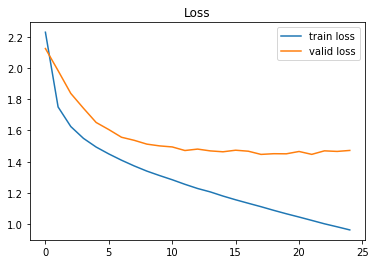

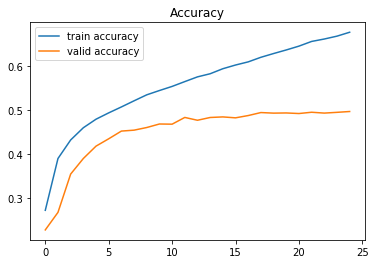

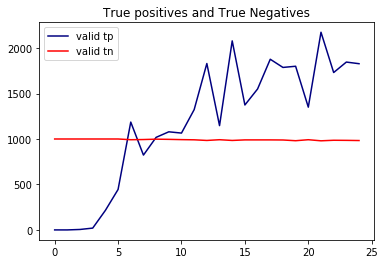

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
